__References__
- https://kharchenkolab.github.io/Baysor/dev/segmentation/
- https://www.10xgenomics.com/analysis-guides/using-baysor-to-perform-xenium-cell-segmentation  
- https://celltypist.readthedocs.io/en/latest/notebook/celltypist_tutorial.html  

# Creating an virtual environment  
1. ``micromamba activate biml2025``
2. ``micromamba install -c conda-forge scanpy python-igraph leidenalg``
3. ``pip install numpy==1.26.4``
4. ``wget https://github.com/kharchenkolab/Baysor/releases/download/v0.7.1/baysor-x86_x64-linux-v0.7.1_build.zip``  
5. ``unzip baysor-x86_x64-linux-v0.7.1_build.zip``

In [8]:
import os
# Baysor 실행 파일이 위치한 경로를 PATH 앞쪽에 추가
os.environ["PATH"] = "/bce/groups/pnucolab/analysis/BIML2025/Session2_Baysor/bin/baysor/bin:" + os.environ["PATH"]

# 이제 'baysor' 명령어로 실행할 수 있음.
!baysor --help



  baysor v0.7.1



Usage

  baysor <command>

Commands

  preview                                                   Plot an html with the dataset preview.

  run                                                       Run cell segmentation

  segfree                                                   Extract Neighborhood Composition Vectors (NCVs) from a
                                                            dataset



Flags

  -h, --help                                                Print this help message.
  --version                                                 Print version.


In [ ]:
import pandas as pd

def filter_transcripts(transcript,
                       min_qv=20.0,
                       min_x=3000.0,
                       max_x=4000.0,
                       min_y=4500.0,
                       max_y=5500.0):
    """
    주어진 transcripts CSV 파일을 읽어서 조건에 맞게 필터링한 후, 
    결과를 CSV 파일로 저장합니다.
    
    Parameters:
        transcript (str): 입력 CSV 파일 경로.
        min_qv (float): 최소 Q-Score. (default: 20.0)
        min_x (float): 최소 x좌표. (default: 0.0)
        max_x (float): 최대 x좌표. (default: 24000.0)
        min_y (float): 최소 y좌표. (default: 0.0)
        max_y (float): 최대 y좌표. (default: 24000.0)
    """
    # CSV 파일 읽기
    data_frame = pd.read_csv(transcript)
    
    # 조건에 따라 필터링 (음성 대조군 제외)
    filtered_frame = data_frame[
        (data_frame["qv"] >= min_qv) &
        (data_frame["x_location"] >= min_x) &
        (data_frame["x_location"] <= max_x) &
        (data_frame["y_location"] >= min_y) &
        (data_frame["y_location"] <= max_y) &
        (~data_frame["feature_name"].str.startswith("NegControlProbe_")) &
        (~data_frame["feature_name"].str.startswith("antisense_")) &
        (~data_frame["feature_name"].str.startswith("NegControlCodeword_")) &
        (~data_frame["feature_name"].str.startswith("BLANK_"))
    ]
    
    # cell_id가 -1인 경우 0으로 변경
    neg_cell_row = filtered_frame["cell_id"] == -1
    filtered_frame.loc[neg_cell_row, "cell_id"] = 0
    
    # 출력 파일 이름 생성 및 CSV 저장
    output_filename = f"X{min_x}-{max_x}_Y{min_y}-{max_y}_filtered_transcripts.csv"
    filtered_frame.to_csv(output_filename, index=False, encoding='utf-8')
    print(f"필터링된 결과가 {output_filename} 파일에 저장되었습니다.")

# --------------------------------------------------------------------

def run_filter_example():
    """
    Example run function to demonstrate usage.
    Example:
        run_filter_example()  # transcripts.csv 파일이 현재 디렉토리에 있다고 가정.
    """
    # 파일 경로 및 필터 파라미터 설정
    transcript_file = "/bce/groups/pnucolab/data/visiumhd-xenium-human-crc/Xenium_In_Situ_Sample_P1_CRC/output/transcripts.csv.gz"  # 여기에 실제 파일 경로를 입력하세요.
    min_qv = 20.0
    min_x = 3000.0
    max_x = 4000.0
    min_y = 4500.0
    max_y = 5500.0
    
    # 필터 함수 실행
    filter_transcripts(transcript_file, min_qv, min_x, max_x, min_y, max_y)

# --------------------------------------------------------------------

run_filter_example()

필터링된 결과가 X3000.0-4000.0_Y4500.0-5500.0_filtered_transcripts.csv 파일에 저장되었습니다.


In [14]:
filtered_transcripts_csv = "/bce/groups/pnucolab/analysis/BIML2025/dataset_final/X3000.0-4000.0_Y4500.0-5500.0_filtered_transcripts.csv"

pd.read_csv(filtered_transcripts_csv).head()

transcript_id     cell_id  overlaps_nucleus feature_name  x_location  \
0  281809984165310  hjjedkph-1                 1      HLA-DRA   3000.6638   
1  281809984165318  hihafhcl-1                 0        SPDEF   3002.2664   
2  281809984165323  hjjedkph-1                 1      HLA-DRA   3003.0269   
3  281809984165329  hjjedkph-1                 1      HLA-DRA   3003.5881   
4  281809984165338  UNASSIGNED                 0       LRATD1   3005.6504   

   y_location  z_location         qv fov_name  nucleus_distance  \
0   4589.9030   20.367735  24.831318       Y7          0.000000   
1   4713.3125   21.332820  40.000000       Y7          4.612793   
2   4591.7380   17.572792  40.000000       Y7          0.000000   
3   4593.4450   18.277754  24.831318       Y7          0.000000   
4   4664.2275   17.218480  40.000000       Y7         20.993397   

   codeword_index  
0             424  
1             234  
2             424  
3             424  
4             434

In [19]:
# baysor preview [transcripts.csv] -x [name of x column] -y [name of y column] -z [name of z column] -g [name of gene column] -m [min molescules per cell]
!baysor preview {filtered_transcripts_csv} -x x_location -y y_location -z z_location -g feature_name -m 15

[01:25:01] Info: # CLI params: `/bce/groups/pnucolab/analysis/BIML2025/dataset_final/X3000.0-4000.0_Y4500.0-5500.0_filtered_transcripts.csv -x x_location -y y_location -z z_location -g feature_name -m 15`
[01:25:01] Info: (2025-02-25) Run Baysor v0.7.1
[01:25:01] Info: Loading data...
[01:25:08] Info: Loaded 843219 transcripts, 439 genes.
[01:25:09] Info: Estimating noise level
[01:25:26] Info: Done
[01:25:26] Info: Estimating local colors
[01:27:04] Info: Building transcript plots
[01:27:06] Info: Building gene structure plot
[01:27:37] Info: Plotting
[01:28:08] Info: All done!

(process:812246): GLib-CRITICAL **: 01:28:08.346: g_datalist_id_set_data_full: assertion 'key_id > 0' failed

(process:812246): GLib-CRITICAL **: 01:28:08.346: g_datalist_id_set_data_full: assertion 'key_id > 0' failed


__`baysor preview` outputs :__  
- `preview.html`

---

In [20]:
# baysor run [transcripts.csv] -x [name of x column] -y [name of y column] -z [name of z column] -g [name of gene column] -m [min molescules per cell] [prior segmentation] --prior-segmentation-confidence 0.5 :cell_id
!baysor run {filtered_transcripts_csv} -x x_location -y y_location -z z_location -g feature_name -m 15 :cell_id --prior-segmentation-confidence 0.5 

[01:39:45] Info: Run R87a891a26
[01:39:45] Info: (2025-02-25) Run Baysor v0.7.1
[01:39:45] Info: Loading data...
[01:39:53] Info: Loaded 843219 transcripts, 439 genes.
[01:39:54] Warning: No unassigned molecules found in the prior segmentation. Did you specify the unassigned value correctly (0)? Most present assigned value: UNASSIGNED (246304 molecules).
└ Baysor.DataLoading /home/viktor_petukhov/.julia/dev/Baysor/src/data_loading/cli_wrappers.jl:22
[01:39:55] Info: Estimating noise level
[01:40:09] Info: Done
[01:40:23] Info: Clustering molecules...
Progress:   0%|                                         |  ETA: 1:01:47
  Iteration:                  2
  Max. difference:            0.766
4m  Fraction of probs changed:  1.0


Progress:   0%|                                         |  ETA: 1:05:52
  Iteration:                  5
  Max. difference:            0.584
4m  Fraction of probs changed:  1.0


Progress:   0%|                                         |  ETA: 1:00:29
  Iteration:   

__`baysor run` outputs :__  
- `segmentation.csv`
- `segmentation_cell_stats.csv`
- `segmentation_polygons_2d.json`

In [21]:
pd.read_csv('segmentation.csv').head()

transcript_id     cell_id  overlaps_nucleus     gene          x  \
0  281809984165310  hjjedkph-1                 1  HLA-DRA  3000.6638   
1  281809984165318  hihafhcl-1                 0    SPDEF  3002.2664   
2  281809984165323  hjjedkph-1                 1  HLA-DRA  3003.0269   
3  281809984165329  hjjedkph-1                 1  HLA-DRA  3003.5881   
4  281809984165338  UNASSIGNED                 0   LRATD1  3005.6504   

           y          z         qv fov_name  nucleus_distance  codeword_index  \
0  4589.9030  20.367735  24.831318       Y7          0.000000             424   
1  4713.3125  21.332820  40.000000       Y7          4.612793             234   
2  4591.7380  17.572792  40.000000       Y7          0.000000             424   
3  4593.4450  18.277754  24.831318       Y7          0.000000             424   
4  4664.2275  17.218480  40.000000       Y7         20.993397             434   

   molecule_id  prior_segmentation  confidence  cluster             cell  \
0            1                6089     0.99980        1   CR87a891a26-70   
1            2                5024     0.99986        3  CR87a891a26-473   
2            3                6089     0.99728        1   CR87a891a26-70   
3            4                6089     0.99865        1   CR87a891a26-70   
4            5                   1     0.44968        3  CR87a891a26-241   

   assignment_confidence  is_noise ncv_color  
0                   0.98     False   #3135C4  
1                   1.00     False   #00EAFF  
2                   1.00     False   #002BA0  
3                   1.00     False   #002CA4  
4                   1.00     False   #00D9FF

In [22]:
pd.read_csv('segmentation_cell_stats.csv').head()

cell            x            y          z  cluster  n_transcripts  \
0  CR87a891a26-1  3001.661071  4500.677986  22.789265        3              7   
1  CR87a891a26-2  3003.996167  4507.558283  18.980074        3              6   
2  CR87a891a26-3  3006.314014  4502.744005  21.110086        3             22   
3  CR87a891a26-4  3002.427280  4517.820480  21.160224        3              5   
4  CR87a891a26-5  3010.020300  4514.682883  20.155191        3              6   

   density  elongation     area  avg_confidence  avg_assignment_confidence  \
0   2.0980       4.407   3.3360          0.7923                        1.0   
1   1.2540      10.110   4.7850          0.6841                        1.0   
2   0.5075       5.437  43.3500          0.6886                        1.0   
3   1.9590       6.375   2.5520          0.5895                        1.0   
4  16.1600       8.003   0.3714          0.2500                        1.0   

   max_cluster_frac  lifespan  
0          1.000000        50  
1          0.833333        50  
2          0.954545        50  
3          0.600000        50  
4          1.000000        50

# Converting Baysor outputs to Anndata

Transform `segmentation.csv` to `barocdes.tsv.gz`, `features.tsv.gz`, `matrix.mtx.gz`

In [19]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import scipy.io as sio
import csv
import subprocess


baysor_file = "/bce/groups/pnucolab/analysis/BIML2025/dataset_final/segmentation.csv"  # Path to the segmentation CSV file
output_folder = "baysor_mtx"        # Name of the output folder
conf_cutoff = 0.9                   # Confidence cutoff threshold 
rep_int = 100000                    # Reporting interval for processed transcripts 


if not os.path.exists(baysor_file):
    print(f"The specified Baysor file ({baysor_file}) does not exist!")
    raise FileNotFoundError(f"Baysor file {baysor_file} not found.")

if os.path.exists(output_folder):
    print(f"The specified output folder ({output_folder}) already exists!")
    raise FileExistsError(f"Output folder {output_folder} already exists.")


transcripts_df = pd.read_csv(baysor_file, usecols=["gene", "cell", "assignment_confidence"])

features = np.unique(transcripts_df["gene"])

feature_to_index = {str(val): index for index, val in enumerate(features)}

cells = np.unique(transcripts_df["cell"].astype(str))
cells = cells[cells != "0"]

matrix = pd.DataFrame(0, index=range(len(features)), columns=cells, dtype=np.int32)


for idx, row in transcripts_df.iterrows():
    if idx % rep_int == 0:
        print(f"{idx} transcripts processed.")
    feature = str(row['gene'])
    cell = str(row['cell']) 
    conf = row['assignment_confidence']
    
    if conf < conf_cutoff:
        continue
    
    if cell != "0":
        matrix.at[feature_to_index[feature], cell] += 1

matrix = matrix.T


def write_sparse_mtx(matrix, cell_names, gene_names, output_folder):
   
    os.mkdir(output_folder)
    
    sparse_mat = sparse.coo_matrix(matrix.values)
    
    sio.mmwrite(os.path.join(output_folder, "matrix.mtx"), sparse_mat)
    
    with open(os.path.join(output_folder, "barcodes.tsv"), 'w', newline='') as tsvfile:
        writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
        for cell in cell_names:
            writer.writerow([f"cell_{cell}"])
    
    # Write genes as features.tsv with three columns.
    with open(os.path.join(output_folder, "features.tsv"), 'w', newline='') as tsvfile:
        writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
        for gene in gene_names:
            gene_str = str(gene)
            if gene_str.startswith("NegControlProbe_") or gene_str.startswith("antisense_"):
                writer.writerow([gene_str, gene_str, "Negative Control Probe"])
            elif gene_str.startswith("NegControlCodeword_"):
                writer.writerow([gene_str, gene_str, "Negative Control Codeword"])
            elif gene_str.startswith("BLANK_"):
                writer.writerow([gene_str, gene_str, "Blank Codeword"])
            else:
                writer.writerow([gene_str, gene_str, "Gene Expression"])
    
    subprocess.run("gzip -f " + os.path.join(output_folder, "*"), shell=True)
    print("Output files written and gzipped.")

# Call the helper function to write the MTX and associated files.
# 관측치(cell) 목록은 matrix의 index, 유전자 목록은 원본 gene 이름(features)를 사용합니다.
write_sparse_mtx(matrix, matrix.index, features, output_folder)


0 transcripts processed.
100000 transcripts processed.
200000 transcripts processed.
300000 transcripts processed.
400000 transcripts processed.
500000 transcripts processed.
600000 transcripts processed.
700000 transcripts processed.
800000 transcripts processed.
Output files written and gzipped.


Transform `barocdes.tsv.gz`, `features.tsv.gz`, `matrix.mtx.gz` to `Anndata`

In [ ]:
import scanpy as sc
import anndata as ad
import pandas as pd


mat = sc.read_mtx("baysor_mtx/matrix.mtx.gz")

barcodes = pd.read_csv("baysor_mtx/barcodes.tsv.gz", header=None, sep='\t', compression='gzip')
cell_names = barcodes[0].values

features = pd.read_csv("baysor_mtx/features.tsv.gz", header=None, sep='\t', compression='gzip')
gene_names = features[0].values


adata = ad.AnnData(X=mat.X)
adata.obs_names = cell_names  
adata.var_names = gene_names  

if features.shape[1] >= 3:
    adata.var['feature_type'] = features[2].values

print(adata)

AnnData object with n_obs × n_vars = 16636 × 439
    var: 'feature_type'


In [24]:
# filter "UnassignedCodeword" 

print(len(adata.var))

mask = ~adata.var_names.str.startswith("UnassignedCodeword")
adata = adata[:, mask]

print(len(adata.var))

439
422


In [25]:
adata.var_names_make_unique()

# Analyzing Anndata using Scanpy

/home/baejs/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


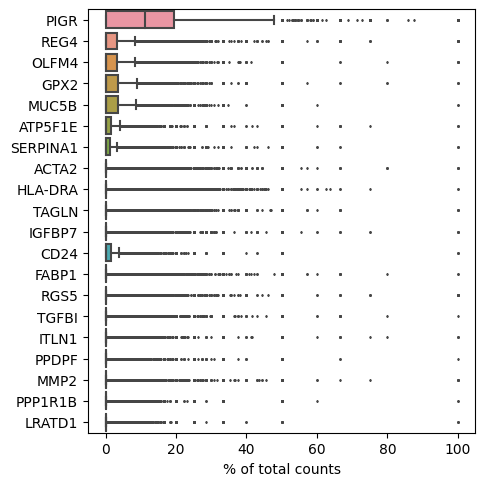

In [26]:
adata.X = adata.X.toarray()
sc.pl.highest_expr_genes(adata, n_top=20)

In [27]:
sc.pp.calculate_qc_metrics(
    adata, percent_top=None, log1p=False, inplace=True
)

/home/baejs/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/baejs/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/baejs/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/baejs/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be remo

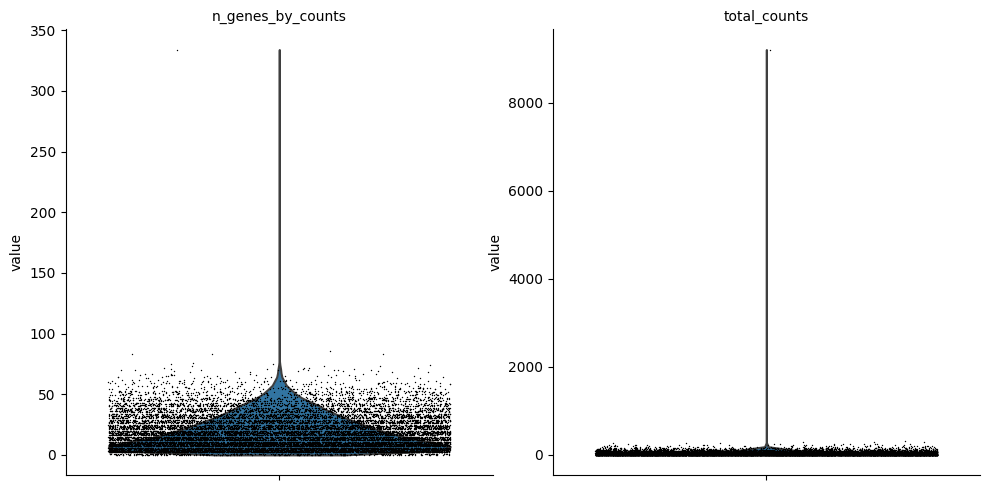

In [28]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

In [29]:
adata = adata[adata.obs['total_counts'] < 2000]

/home/baejs/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/baejs/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/baejs/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/baejs/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be remo

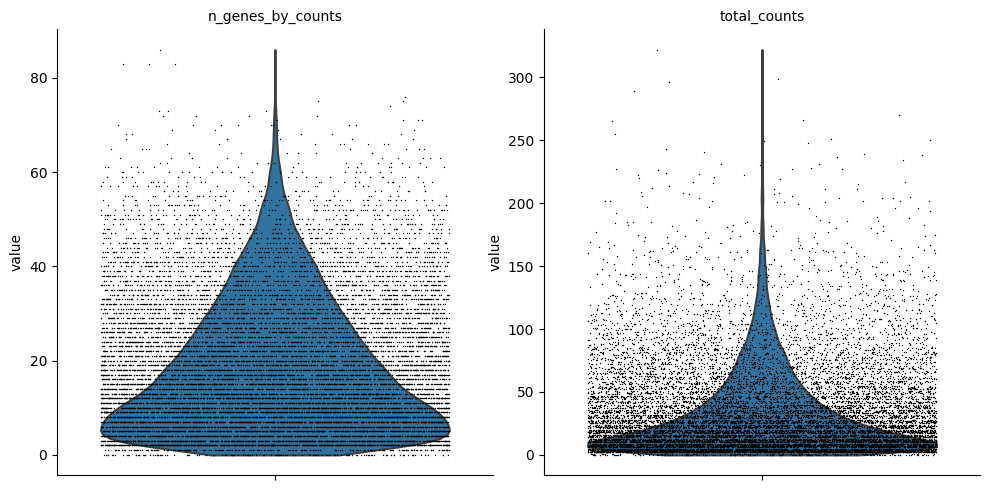

In [30]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

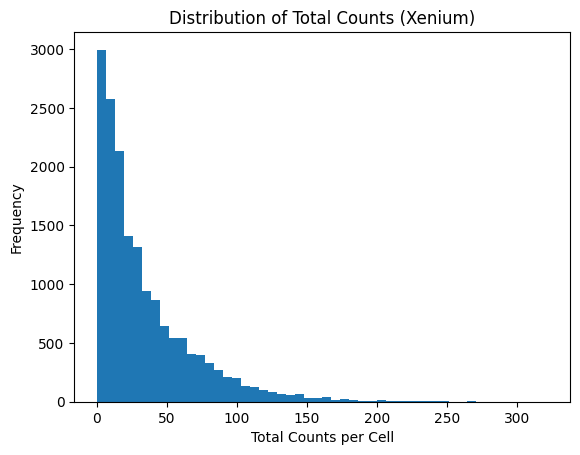

In [31]:
import matplotlib.pyplot as plt

plt.hist(adata.obs['total_counts'], bins=50)
plt.xlabel('Total Counts per Cell')
plt.ylabel('Frequency')
plt.title('Distribution of Total Counts (Xenium)')
plt.show()

In [32]:
median_total_counts = adata.obs['total_counts'].median()
print("Median total_counts:", median_total_counts)

Median total_counts: 22.0


In [33]:
# Normalizing to median total counts
sc.pp.normalize_total(adata,target_sum=None)

# Logarithmize the data
sc.pp.log1p(adata)

/home/baejs/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/baejs/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


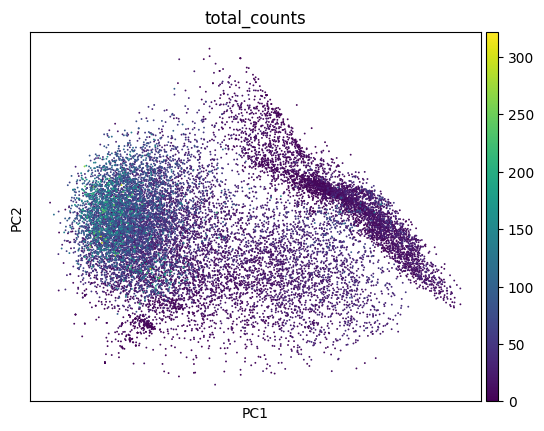

In [34]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca(adata, color="total_counts")

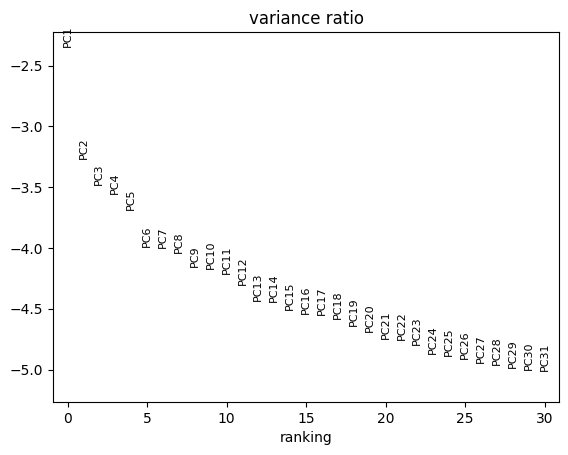

In [35]:
sc.pl.pca_variance_ratio(adata, log=True)

In [36]:
sc.pp.neighbors(adata)

In [37]:
sc.tl.umap(adata)

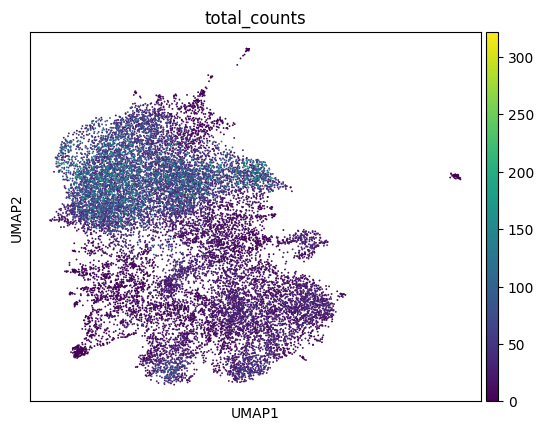

In [38]:
sc.pl.umap(
    adata,
    color="total_counts",
)

In [40]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, n_iterations=2)

/home/baejs/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/baejs/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


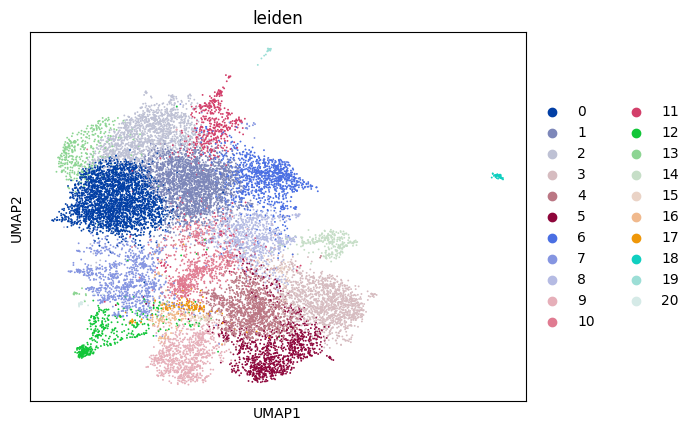

In [41]:
sc.pl.umap(adata, color=["leiden"])

# Celltypist

In [53]:
!pip install celltypist

  Using cached celltypist-1.6.3-py3-none-any.whl (7.3 MB)

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [42]:
import celltypist
from celltypist import models

In [57]:
!wget https://celltypist.cog.sanger.ac.uk/models/Colorectal_Cancer_Lee/v1/Human_Colorectal_Cancer.pkl

--2025-02-25 03:04:59--  https://celltypist.cog.sanger.ac.uk/models/Colorectal_Cancer_Lee/v1/Human_Colorectal_Cancer.pkl
Resolving celltypist.cog.sanger.ac.uk (celltypist.cog.sanger.ac.uk)... 193.62.203.62, 193.62.203.61, 193.62.203.63
Connecting to celltypist.cog.sanger.ac.uk (celltypist.cog.sanger.ac.uk)|193.62.203.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 761458 (744K) [application/octet-stream]
Saving to: ‘Human_Colorectal_Cancer.pkl’

Human_Colorectal_Ca 100%[===================>] 743.61K   620KB/s    in 1.2s    

2025-02-25 03:05:02 (620 KB/s) - ‘Human_Colorectal_Cancer.pkl’ saved [761458/761458]



In [43]:
models.models_path=os.getcwd()
model = models.Model.load(model='Human_Colorectal_Cancer.pkl')
model

CellTypist model with 36 cell types and 4301 features
    date: 2024-04-26 20:47:44.844844
    details: cell types of colon tissues from patients with colorectal cancer
    source: https://doi.org/10.1038/s41588-020-0636-z
    version: v1
    cell types: CD19+CD20+ B, CD4+ T cells, ..., gamma delta T cells
    features: A1BG, A1CF, ..., ZWINT

In [44]:
predictions = celltypist.annotate(adata, model='Human_Colorectal_Cancer.pkl', majority_voting = True)

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 16635 cells and 422 genes
🔗 Matching reference genes in the model
🧬 351 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [45]:
predictions.predicted_labels

predicted_labels over_clustering majority_voting
cell_CR29d885ccb-1         CD19+CD20+ B               3    CD19+CD20+ B
cell_CR29d885ccb-10        CD19+CD20+ B               3    CD19+CD20+ B
cell_CR29d885ccb-100               CMS2             118            CMS2
cell_CR29d885ccb-1000    Myofibroblasts              71            CMS2
cell_CR29d885ccb-10000             CMS2              31            CMS2
...                                 ...             ...             ...
cell_CR29d885ccb-9995              CMS2              28    CD19+CD20+ B
cell_CR29d885ccb-9996        Mast cells              89      Mast cells
cell_CR29d885ccb-9997      CD19+CD20+ B              62    CD19+CD20+ B
cell_CR29d885ccb-9998      CD19+CD20+ B              78            CMS2
cell_CR29d885ccb-9999              CMS2              34    CD19+CD20+ B

[16635 rows x 3 columns]

In [46]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

In [47]:
adata.obs['predicted_labels']

cell_CR29d885ccb-1          CD19+CD20+ B
cell_CR29d885ccb-10         CD19+CD20+ B
cell_CR29d885ccb-100                CMS2
cell_CR29d885ccb-1000     Myofibroblasts
cell_CR29d885ccb-10000              CMS2
                               ...      
cell_CR29d885ccb-9995               CMS2
cell_CR29d885ccb-9996         Mast cells
cell_CR29d885ccb-9997       CD19+CD20+ B
cell_CR29d885ccb-9998       CD19+CD20+ B
cell_CR29d885ccb-9999               CMS2
Name: predicted_labels, Length: 16635, dtype: category
Categories (26, object): ['CD19+CD20+ B', 'CD4+ T cells', 'CMS1', 'CMS2', ..., 'Stromal 3', 'T helper 17 cells', 'Tip-like ECs', 'cDC']

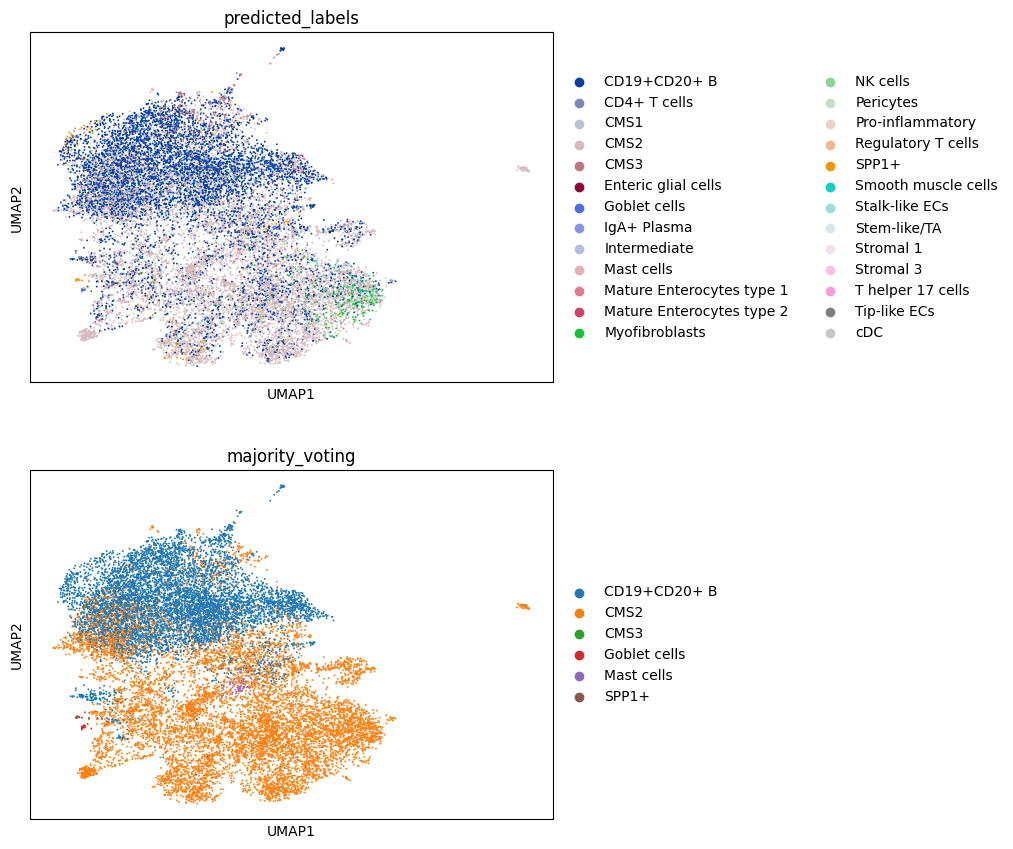

In [48]:
sc.pl.umap(adata, color = ['predicted_labels', 'majority_voting'], ncols=1)

# Xenium dataset to SpatialData

## Loading & Cropping data

In [57]:
!tree -L 3 /bce/groups/pnucolab/data/visiumhd-xenium-human-crc/Xenium_In_Situ_Sample_P1_CRC/output

/bce/groups/pnucolab/data/visiumhd-xenium-human-crc/Xenium_In_Situ_Sample_P1_CRC/output
├── analysis_summary.html
├── analysis.tar.gz
├── analysis.zarr.zip
├── aux_outputs.tar.gz
├── cell_boundaries.csv.gz
├── cell_boundaries.parquet
├── cell_feature_matrix.h5
├── cell_feature_matrix.tar.gz
├── cell_feature_matrix.zarr.zip
├── cells.csv.gz
├── cells.parquet
├── cells.zarr.zip
├── experiment.xenium
├── filter_transcripts.py.save
├── gene_panel.json
├── metrics_summary.csv
├── morphology_focus
│   ├── morphology_focus_0000.ome.tif
│   ├── morphology_focus_0001.ome.tif
│   ├── morphology_focus_0002.ome.tif
│   └── morphology_focus_0003.ome.tif
├── morphology.ome.tif
├── nucleus_boundaries.csv.gz
├── nucleus_boundaries.parquet
├── transcripts.csv.gz
├── transcripts.parquet
├── transcripts.zarr.zip
├── Xenium_V1_Human_Colon_Cancer_P1_CRC_Add_on_FFPE_analysis_summary.html
└── Xenium_V1_Human_Colon_Cancer_P1_CRC_Add_on_FFPE_outs.zip

2 directories, 28 files


In [2]:
import spatialdata as sd
import spatialdata_plot 
import spatialdata_io

/home/baejs/micromamba/envs/2025biml/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/baejs/micromamba/envs/2025biml/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/baejs/micromamba/envs/2025biml/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/baejs/micromamba/envs/2025biml/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_

In [ ]:
sdata = spatialdata_io.xenium('/bce/groups/pnucolab/analysis/BIML2025/Xeniumdataset')
sdata

INFO     reading /bce/groups/pnucolab/analysis/BIML2025/Xeniumdataset/cell_feature_matrix.h5                       


/tmp/ipykernel_941267/180082551.py:1: DeprecationWarning: The default value of `cells_as_circles` will change to `False` in the next release. Please pass `True` explicitly to maintain the current behavior.
  sdata = spatialdata_io.xenium('/bce/groups/pnucolab/analysis/BIML2025/Xeniumdataset')


SpatialData object
├── Images
│     └── 'morphology_focus': DataTree[cyx] (5, 34111, 31345), (5, 17055, 15672), (5, 8527, 7836), (5, 4263, 3918), (5, 2131, 1959)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (34111, 31345), (17055, 15672), (8527, 7836), (4263, 3918), (2131, 1959)
│     └── 'nucleus_labels': DataTree[yx] (34111, 31345), (17055, 15672), (8527, 7836), (4263, 3918), (2131, 1959)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (307762, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (307762, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (299564, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (307762, 422)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (Shape

/home/baejs/micromamba/envs/2025biml/lib/python3.10/site-packages/tifffile/tifffile.py:8813: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  warnings.warn(
/home/baejs/micromamba/envs/2025biml/lib/python3.10/site-packages/tifffile/tifffile.py:8813: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  warnings.warn(


https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/spatial_query.html

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                     

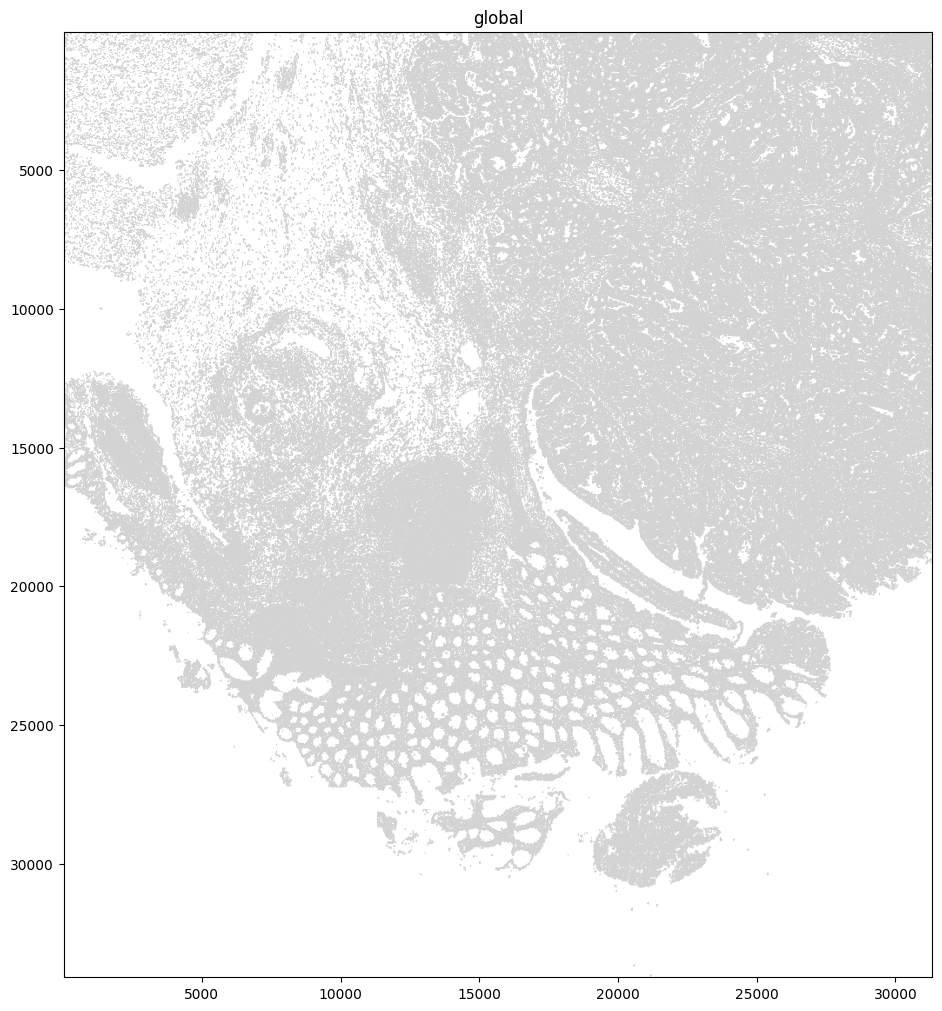

In [4]:
sdata.pl.render_shapes().pl.show(figsize=(10, 10))

In [4]:
# https://kb.10xgenomics.com/hc/en-us/articles/11636252598925-What-are-the-Xenium-image-scale-factors
# pixel size (um) = 0.2125

pixel_size = 0.2125

bb_xmin = 3000*(1/pixel_size)
bb_ymin = 4500*(1/pixel_size)
bb_w = 1000*(1/pixel_size)
bb_h = 1000*(1/pixel_size)
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                     

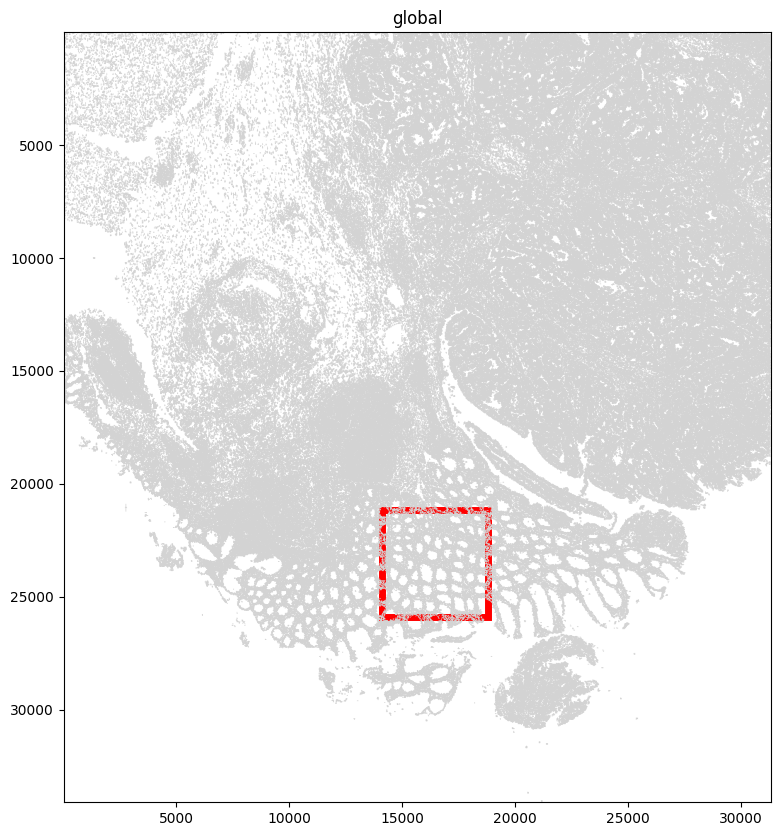

In [7]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
sdata.pl.render_shapes().pl.show(ax=ax)
rect = patches.Rectangle((bb_xmin, bb_ymin), bb_w, bb_h, linewidth=5, edgecolor="red", facecolor="none")
ax.add_patch(rect)

In [5]:
sdata_crop = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
)

sdata_crop

/home/baejs/micromamba/envs/2025biml/lib/python3.10/functools.py:889: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/home/baejs/micromamba/envs/2025biml/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object
├── Images
│     └── 'morphology_focus': DataTree[cyx] (5, 4706, 4706), (5, 2353, 2352), (5, 1176, 1177), (5, 588, 588), (5, 294, 294)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (4706, 4706), (2353, 2352), (1176, 1177), (588, 588), (294, 294)
│     └── 'nucleus_labels': DataTree[yx] (4706, 4706), (2353, 2352), (1176, 1177), (588, 588), (294, 294)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (9999, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (9840, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (9848, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (9840, 422)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (Shapes)

In [6]:
sdata_crop.write('xenium_sdata_cropped.zarr')

INFO     The Zarr backing store has been changed from None the new file path: xenium_sdata_cropped.zarr            


## Loading cropped SpatialData file (.zarr)

In [ ]:
sdata_crop = sd.read_zarr('xenium_sdata_cropped.zarr')

## Plotting

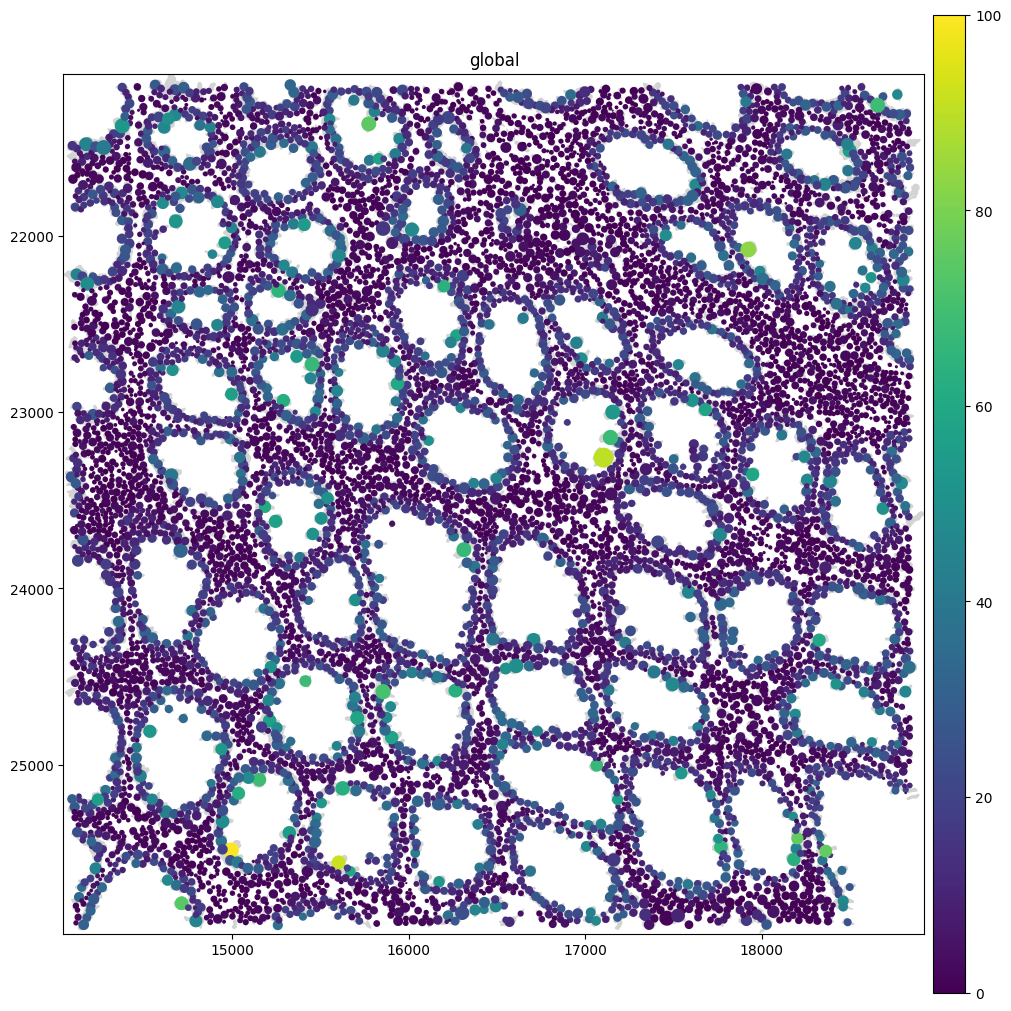

In [80]:
sdata_crop.pl.render_shapes(color="PIGR").pl.show(figsize=(10, 10))

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO     Rasterizing image for faster rendering.                                                                   


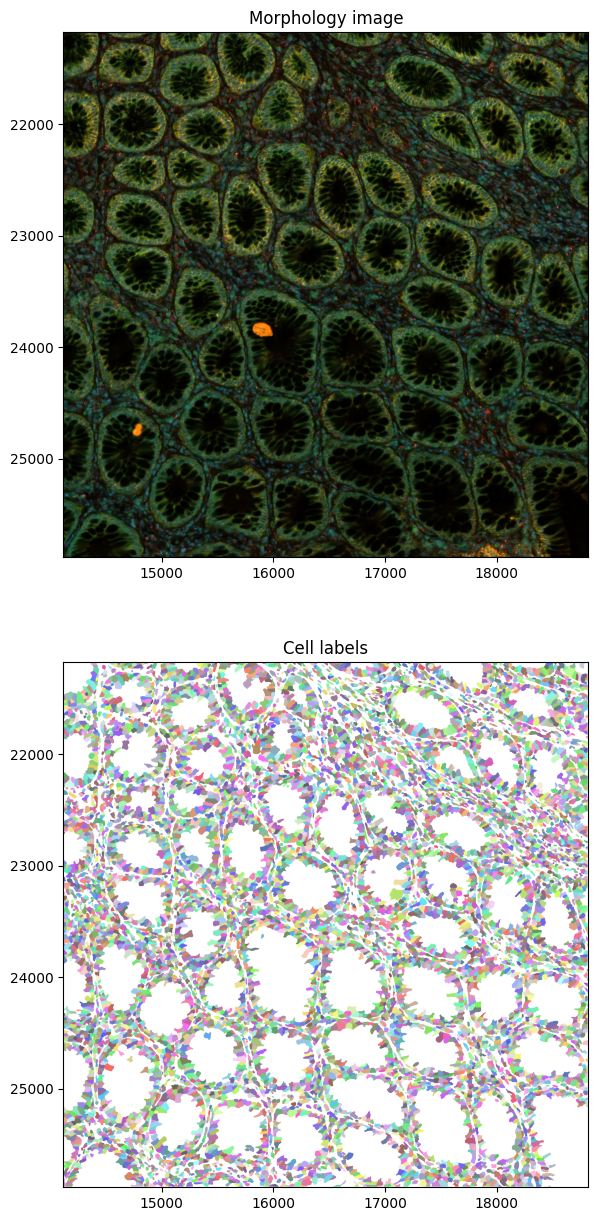

In [7]:
import matplotlib.pyplot as plt

axes = plt.subplots(2, 1, figsize=(25, 15))[1].flatten()

sdata_crop.pl.render_images("morphology_focus").pl.show(
    ax=axes[0], title="Morphology image", coordinate_systems="global"
)
sdata_crop.pl.render_labels("cell_labels").pl.show(ax=axes[1], title="Cell labels", coordinate_systems="global")

In [8]:
import json
import geopandas as gpd
from shapely.geometry import shape

# 1. JSON 파일 읽기 (파일 경로를 적절히 수정)
with open("segmentation_polygons_2d.json", "r") as f:
    data = json.load(f)

# 2. data['features']에서 각 feature의 id와 geometry를 추출하여 레코드 리스트 생성
records = []
for feat in data["features"]:
    cell_id = feat.get("id")
    # shapely의 shape() 함수를 이용하여 geometry 객체 생성
    geom = shape(feat.get("geometry"))
    records.append({"id": cell_id, "geometry": geom})

# 3. GeoDataFrame 생성
gdf = gpd.GeoDataFrame(records)

gdf = gdf.set_index('id')
gdf.index.name = None  # 인덱스 이름 제거

# 결과 확인
print(type(gdf))  # <class 'geopandas.geodataframe.GeoDataFrame'>
print(gdf.head())


<class 'geopandas.geodataframe.GeoDataFrame'>
                                                            geometry
CR87a891a26-1204   POLYGON ((3060.547 4809.039, 3059.249 4809.577...
CR87a891a26-10625  POLYGON ((3444.625 5179.076, 3440.013 5177.563...
CR87a891a26-4808   POLYGON ((3465.828 4765.321, 3465.296 4766.617...
CR87a891a26-3640   POLYGON ((3452.73 4687.373, 3448.72 4679.53, 3...
CR87a891a26-1855   POLYGON ((3188.893 4774.182, 3184.54 4777.208,...


In [9]:
from shapely.affinity import scale

# 각 geometry에 대해 x, y 방향으로 factor만큼 스케일링합니다.
gdf["geometry"] = gdf["geometry"].apply(lambda geom: scale(geom, xfact=(1/pixel_size), yfact=(1/pixel_size), origin=(0, 0)))

In [10]:
from spatialdata.models import ShapesModel

sdata_crop.shapes['cell_boundaries_baysor'] = ShapesModel.parse(gdf)

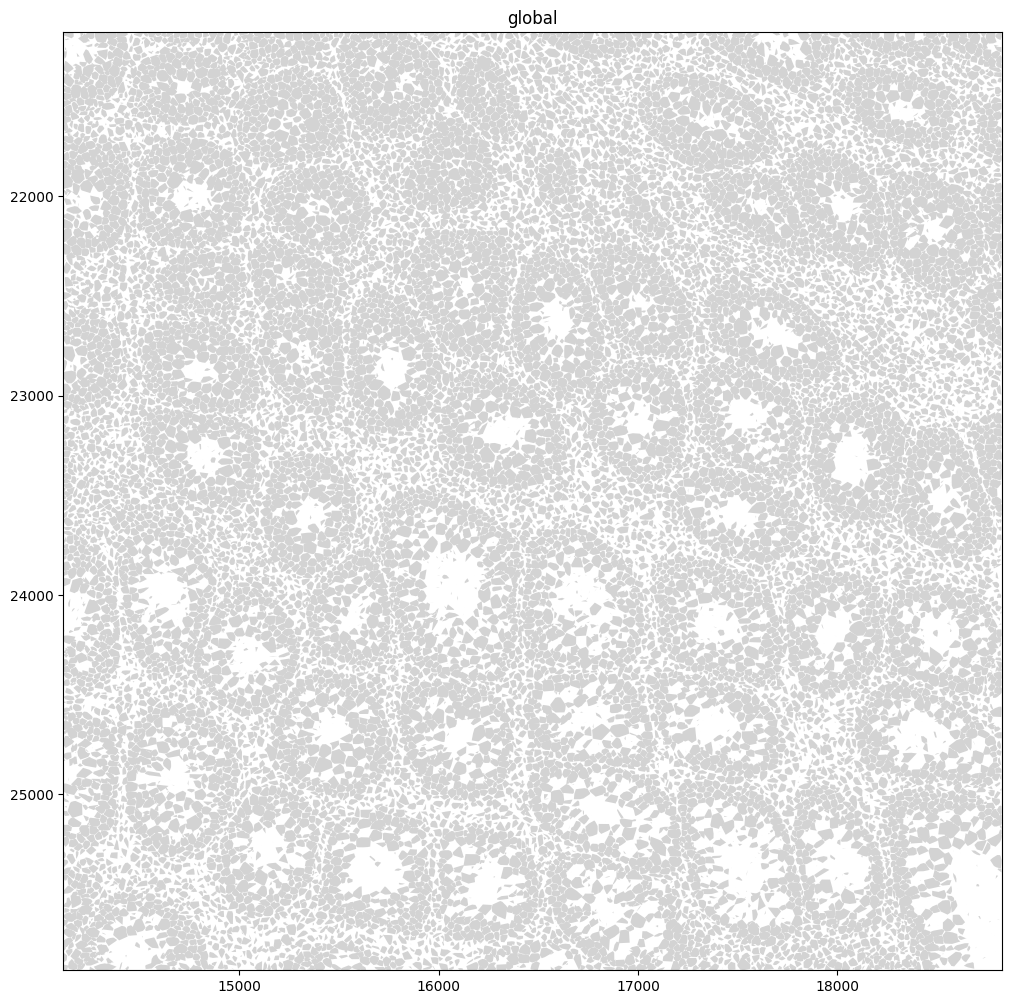

In [13]:
sdata_crop.pl.render_shapes("cell_boundaries_baysor", method='matplotlib').pl.show(coordinate_systems="global", figsize=(10, 10))

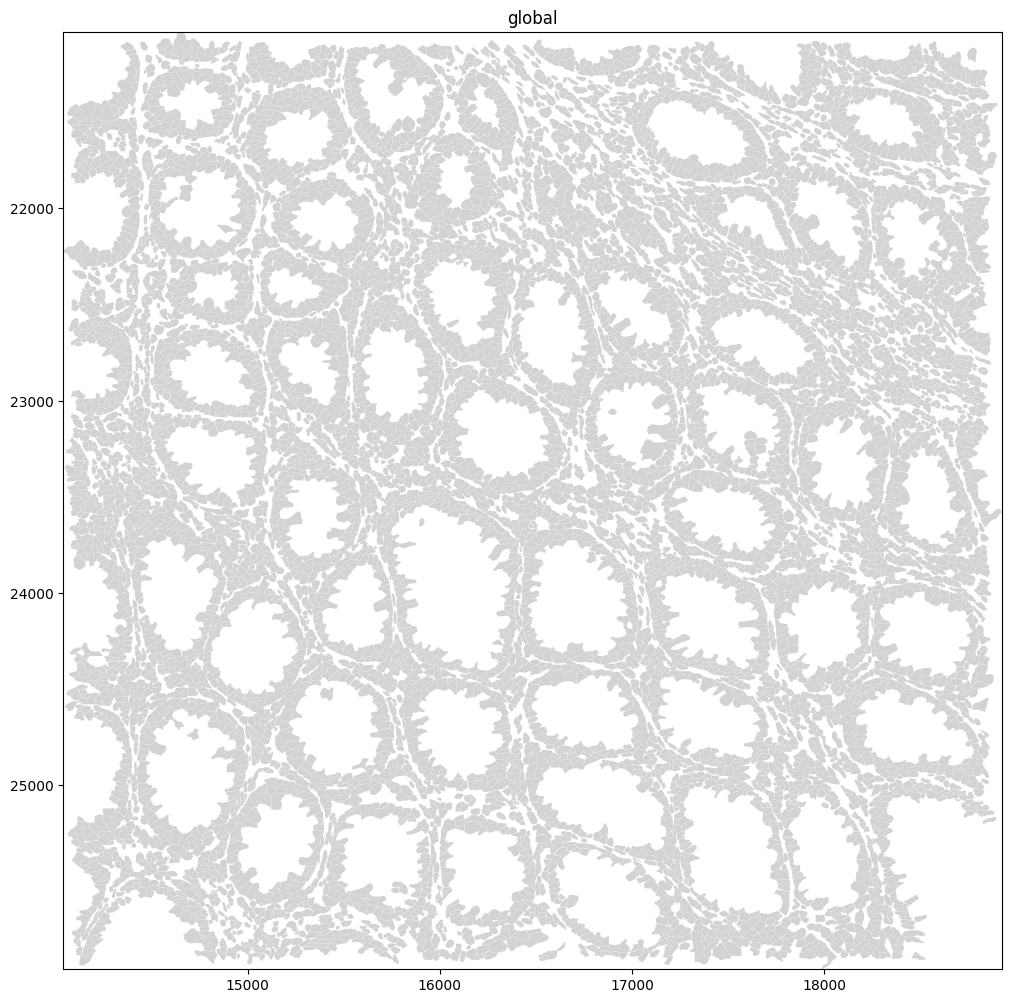

In [14]:
sdata_crop.pl.render_shapes("cell_boundaries", method='matplotlib').pl.show(coordinate_systems="global", figsize=(10, 10))